In [1]:
import pandas as pd
df = pd.read_csv("expense.csv")
df.info()
df['Category'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Expense in ‚Çπ    6000 non-null   int64 
 1   Notes           6000 non-null   object
 2   Payment Method  6000 non-null   object
 3   Date            6000 non-null   object
 4   For What        6000 non-null   object
 5   Category        6000 non-null   object
dtypes: int64(1), object(5)
memory usage: 281.4+ KB


Category
Stationary                489
Personal Expenses         475
Transportation            472
Hotel Charges             472
Digital Tools and Apps    472
Insurance                 466
Health                    462
Recharge                  453
Groceries                 453
Food                      451
Utilities                 450
Savings & Investments     448
Entertainment             437
Name: count, dtype: int64

In [2]:
import re
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r'‚Çπ|\$|,', '', s)       # remove currency symbols/commas
    s = re.sub(r'\d{2,}', ' <AMOUNT> ', s)  # optionally mask large numbers
    s = re.sub(r'[^a-z0-9\s\+\-@.]', ' ', s) 
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text'] = (df['Notes'].fillna('') + ' ' + df['For What'].fillna('')).map(clean_text)

In [4]:
df

Expense in ‚Çπ                                           Notes  \
0            15664                  Fuel expense at HP Petrol Pump   
1            10260                      Security expense at McAfee   
2            14822                       Books expense at Landmark   
3             2504                    Streaming expense at Disney+   
4             3789                   Fruits expense at More Retail   
...            ...                                             ...   
5995          2852  Streaming expense at Stewart, Kaufman and West   
5996           583                    Dairy expense at Rivera-Clay   
5997          3420                Concerts expense at Carrillo Inc   
5998          2969    Hobbies expense at Davis, Fisher and Holland   
5999          1322               Snacks expense at Gonzalez-Wilson   

     Payment Method        Date        For What                Category  \
0        Auto-debit   5/28/2024  HP Petrol Pump          Transportation   
1              Cash   4/18/2025          McAfee  Digital Tools and Apps   
2               UPI  10/24/2024        Landmark              Stationary   
3               UPI   9/27/2023         Disney+           Entertainment   
4              Card   1/20/2024     More Retail               Groceries   
...             ...         ...             ...                     ...   
5995           Card  12/30/2024       Streaming           Entertainment   
5996           Cash   1/17/2025           Dairy               Groceries   
5997           Cash    8/8/2025        Concerts           Entertainment   
5998     Auto-debit   5/19/2024         Hobbies           Entertainment   
5999           Cash   3/18/2025          Snacks               Groceries   

                                                   text  
0         fuel expense at hp petrol pump hp petrol pump  
1                     security expense at mcafee mcafee  
2                    books expense at landmark landmark  
3                  streaming expense at disney+ disney+  
4             fruits expense at more retail more retail  
...                                                 ...  
5995  streaming expense at stewart kaufman and west ...  
5996                 dairy expense at rivera-clay dairy  
5997          concerts expense at carrillo inc concerts  
5998  hobbies expense at davis fisher and holland ho...  
5999           snacks expense at gonzalez-wilson snacks  

[6000 rows x 7 columns]

In [ ]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='ovr'))
])
pipeline.fit(X_train, y_train)

d:\python_ML\.venv_tf\lib\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    multi_class='ovr'))])

In [7]:
pipeline.score(X_test, y_test)*100

99.16666666666667

Classification Report:
                         precision    recall  f1-score   support

Digital Tools and Apps       1.00      1.00      1.00        95
         Entertainment       1.00      0.97      0.98        87
                  Food       0.98      0.94      0.96        90
             Groceries       0.95      0.98      0.96        91
                Health       1.00      1.00      1.00        92
         Hotel Charges       1.00      1.00      1.00        94
             Insurance       1.00      1.00      1.00        93
     Personal Expenses       1.00      1.00      1.00        95
              Recharge       1.00      1.00      1.00        91
 Savings & Investments       1.00      1.00      1.00        90
            Stationary       0.97      1.00      0.98        98
        Transportation       1.00      1.00      1.00        94
             Utilities       1.00      1.00      1.00        90

              accuracy                           0.99      1200
             m

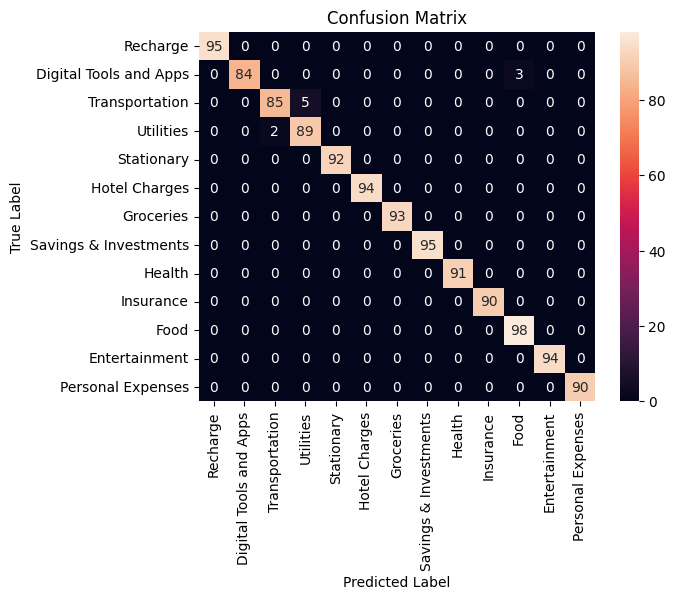

In [8]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# cf = confusion_matrix(y_test, pipeline.predict(X_test))
# sns.heatmap(cf, annot=True,xticklabels=y_test.unique(), yticklabels=y_test.unique())

# or both are same

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [9]:
import os
import joblib

# Ensure the directory exists
os.makedirs("models", exist_ok=True)

# Save the pipeline
joblib.dump(pipeline, "models/expense_pipeline.pkl")


['models/expense_pipeline.pkl']

In [10]:
def predict_category(text):
    # Load model
    pipeline = joblib.load("models/expense_pipeline.pkl")
    
    # Clean input
    cleaned = clean_text(text)
    
    # Predict
    pred = pipeline.predict([cleaned])[0]
    proba = pipeline.predict_proba([cleaned])[0].max()
    
    return pred, proba

# Example usage:
text = "30 for spotify"
category, confidence = predict_category(text)
print(f"Predicted Category: {category}, Confidence: {confidence:.2f}")

Predicted Category: Entertainment, Confidence: 0.65


# along with retraining

In [14]:
import pandas as pd 
import re
import joblib
import os
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1. Download NLTK Data (run once)
# -----------------------------
try:
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
except LookupError:
    print("üì• Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

# -----------------------------
# 2. Text Cleaning Function with NLTK
# -----------------------------
def clean_text(s):
    if pd.isna(s):
        return ""
    
    s = str(s).strip().lower()
    s = re.sub(r'‚Çπ|\$|,|\.', '', s)           # remove currency symbols and commas
    s = re.sub(r'\d{3,}', '<AMOUNT>', s)      # mask large numbers
    
    tokens = word_tokenize(s)
    tokens = [token for token in tokens if re.match(r'^[a-z0-9\+\-\@\_\&<>\s]+$', token)]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    cleaned = ' '.join(tokens)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

# -----------------------------
# 3. Extract ALL Amounts from Text
# -----------------------------
def extract_amounts(text):
    if not isinstance(text, str):
        return []
    matches = re.findall(r'(\d+\.?\d*)', text)
    return [float(match) for match in matches]

# -----------------------------
# 4. Load Trained Model
# -----------------------------
MODEL_PATH = "models/expense_pipeline.pkl"
TRAIN_FILE = "expense.csv"
CORRECTIONS_FILE = "corrections.csv"

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Train it first using train_model.py")

pipeline = joblib.load(MODEL_PATH)

# -----------------------------
# 5. Prediction Function
# -----------------------------
def predict_category(text):
    cleaned = clean_text(text)
    pred = pipeline.predict([cleaned])[0]
    proba = pipeline.predict_proba([cleaned]).max()
    return pred, proba

# -----------------------------
# 6. Retrain Model Using Original Data + Corrections
# -----------------------------
def retrain_model():
    if not os.path.exists(TRAIN_FILE):
        print("‚ö†Ô∏è Training data file 'expense.csv' not found. Skipping retrain.")
        return

    print("üîÑ Retraining model with latest corrections...")

    df_train = pd.read_csv(TRAIN_FILE)
    df_train = df_train[df_train['Category'] != "Category"]
    df_train = df_train.dropna(subset=['Category'])
    df_train['Category'] = df_train['Category'].str.strip()

    if os.path.exists(CORRECTIONS_FILE):
        df_corr = pd.read_csv(CORRECTIONS_FILE)
        df_corr = df_corr.dropna(subset=['correct_category'])
        df_corr = df_corr.rename(columns={'text': 'Notes', 'correct_category': 'Category'})
        df_corr['For What'] = ""
        df_train = pd.concat([df_train, df_corr[['Notes', 'For What', 'Category']]], ignore_index=True)
        print(f"üîÅ Added {len(df_corr)} corrections to training data.")

    df_train['text'] = (df_train['Notes'].fillna('') + ' ' + df_train['For What'].fillna('')).map(clean_text)
    X = df_train['text']
    y = df_train['Category']

    pipeline_new = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 3), min_df=1, max_features=5000)),
        ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='ovr'))
    ])

    pipeline_new.fit(X, y)

    os.makedirs("models", exist_ok=True)
    joblib.dump(pipeline_new, MODEL_PATH)
    print(f"‚úÖ Model retrained and saved to {MODEL_PATH}")

    # open(CORRECTIONS_FILE, 'w').close()
    # print("üóëÔ∏è  Corrections file cleared after retraining.")
    # it causes a problem of deleting main text,correct_category,source,timestamp also

# -----------------------------
# 7. Log One Expense
# -----------------------------
def log_expense(expense_text, output_csv="predicted_expenses.csv", corrections_csv="corrections.csv"):
    predicted_cat, confidence = predict_category(expense_text)
    cleaned_text = clean_text(expense_text)
    amounts = extract_amounts(expense_text)
    total_amount = sum(amounts) if amounts else None

    row = {
        'original_text': expense_text,
        'cleaned_text': cleaned_text,
        'predicted_category': predicted_cat,
        'confidence': round(confidence, 4),
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'amounts': str(amounts),
        'total_amount': total_amount,
        'corrected': None
    }

    # --- ACTIVE LEARNING LOGIC ---
    if confidence >= 0.6:
        row['corrected'] = 0
        print(f"‚úÖ Logged: '{expense_text}' ‚Üí {predicted_cat} (confidence: {confidence:.2f}) [AUTO-ACCEPTED]")
    else:
        print(f"\n‚ö†Ô∏è Low confidence ({confidence:.2f}): Model predicted '{predicted_cat}'")
        print(f"   Text: '{expense_text}'")

        while True:
            user_input = input("‚úÖ Is this correct? (y/n) or type correct category: ").strip().lower()

            if user_input in ['y', 'yes', '']:
                row['corrected'] = predicted_cat
                print(f"‚úîÔ∏è Confirmed: {predicted_cat}\n")
                break

            elif user_input in ['n', 'no']:
                correct_cat = input("üëâ Please enter the correct category: ").strip()
                if correct_cat:
                    row['predicted_category'] = correct_cat
                    row['corrected'] = correct_cat
                    corr_row = {
                        'text': expense_text,
                        'correct_category': correct_cat,
                        'source': 'user_correction',
                        'timestamp': row['timestamp']
                    }
                    df_corr = pd.DataFrame([corr_row])
                    if os.path.exists(corrections_csv):
                        df_corr.to_csv(corrections_csv, mode='a', header=False, index=False)
                    else:
                        df_corr.to_csv(corrections_csv, index=False)
                    print(f"üíæ Correction saved to {corrections_csv}")
                else:
                    row['corrected'] = predicted_cat
                break

            else:
                correct_cat = user_input
                row['predicted_category'] = correct_cat
                row['corrected'] = correct_cat
                corr_row = {
                    'text': expense_text,
                    'correct_category': correct_cat,
                    'source': 'user_correction',
                    'timestamp': row['timestamp']
                }
                df_corr = pd.DataFrame([corr_row])
                if os.path.exists(corrections_csv):
                    df_corr.to_csv(corrections_csv, mode='a', header=False, index=False)
                else:
                    df_corr.to_csv(corrections_csv, index=False)
                print(f"‚úîÔ∏è Corrected to: {correct_cat}\nüíæ Correction saved to {corrections_csv}")
                break

    # --- Save ONLY required columns ---
    df_new = pd.DataFrame([row], columns=[
        'original_text', 'cleaned_text', 'predicted_category',
        'confidence', 'timestamp', 'amounts', 'total_amount', 'corrected'
    ])

    if os.path.exists(output_csv):
        df_existing = pd.read_csv(output_csv)
        df_final = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(output_csv, index=False)

    print(f"‚úÖ Logged: '{expense_text}' ‚Üí {row['predicted_category']} (confidence: {confidence:.2f})")
    if amounts:
        print(f"   Amounts: {amounts} | Total: ‚Çπ{total_amount}")
    print(f"   Saved to: {output_csv}\n")

# -----------------------------
# 8. Auto Retrain on Startup
# -----------------------------
def auto_retrain_on_startup():
    if os.path.exists(CORRECTIONS_FILE) and os.path.getsize(CORRECTIONS_FILE) > 0:
        print("üîç Found untrained corrections. Retraining model...")
        retrain_model()
    else:
        print("‚úÖ No corrections to apply. Using current model.")

# -----------------------------
# 9. Interactive Mode
# -----------------------------
if __name__ == "__main__":
    print("üöÄ Welcome to AI Expense Tracker with Active Learning & NLTK!")
    print("Type any expense description (e.g., '30 for Netflix subscription')")
    print("Type 'quit', 'exit', or 'q' to stop.\n")

    auto_retrain_on_startup()

    while True:
        user_input = input("Enter expense: ").strip()
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("\nüëã Goodbye! Your expenses and corrections have been saved.")
            break
        if not user_input:
            print("‚ö†Ô∏è Please enter a valid expense description.\n")
            continue
        log_expense(user_input)


üöÄ Welcome to AI Expense Tracker with Active Learning & NLTK!
Type any expense description (e.g., '30 for Netflix subscription')
Type 'quit', 'exit', or 'q' to stop.

üîç Found untrained corrections. Retraining model...
üîÑ Retraining model with latest corrections...
üîÅ Added 4 corrections to training data.


d:\python_ML\.venv_tf\lib\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


‚úÖ Model retrained and saved to models/expense_pipeline.pkl

‚ö†Ô∏è Low confidence (0.13): Model predicted 'Entertainment'
   Text: '45 for bottle'
üíæ Correction saved to corrections.csv
‚úÖ Logged: '45 for bottle' ‚Üí utilities (confidence: 0.13)
   Amounts: [45.0] | Total: ‚Çπ45.0
   Saved to: predicted_expenses.csv

‚úÖ Logged: '10 for tea' ‚Üí food (confidence: 0.60) [AUTO-ACCEPTED]
‚úÖ Logged: '10 for tea' ‚Üí food (confidence: 0.60)
   Amounts: [10.0] | Total: ‚Çπ10.0
   Saved to: predicted_expenses.csv

‚úÖ Logged: '50 coffee' ‚Üí Food (confidence: 0.70) [AUTO-ACCEPTED]
‚úÖ Logged: '50 coffee' ‚Üí Food (confidence: 0.70)
   Amounts: [50.0] | Total: ‚Çπ50.0
   Saved to: predicted_expenses.csv


‚ö†Ô∏è Low confidence (0.13): Model predicted 'Entertainment'
   Text: '34 for milk'
üíæ Correction saved to corrections.csv
‚úÖ Logged: '34 for milk' ‚Üí food (confidence: 0.13)
   Amounts: [34.0] | Total: ‚Çπ34.0
   Saved to: predicted_expenses.csv


‚ö†Ô∏è Low confidence (0.13): Mod